### ITGA3 ligand expression in human mesenchyme and mesenchyme co-culture

In [2]:
import os
import glob
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from seaborn import despine
from seaborn import axes_style
import magic # imputation tool; van Dijk et al 2018 # 
from matplotlib.pyplot import suptitle
import matplotlib.colors
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch # for clustermap legends
import time

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

### Organoids

In [3]:
# load mesenchymal cell data
mes_results_file = 'path/to/h5ad'
mes = sc.read(mes_results_file)

at2_results_file = 'path/to/h5ad'
at2Cells = sc.read(at2_results_file)

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


### Check Itga3 ligand expression.
- Ligands were custom curated from Skelly et al, Cell Reports and the CellPhoneDB database

<AxesSubplot:title={'center':'yfp_time_annot'}, xlabel='UMAP1', ylabel='UMAP2'>

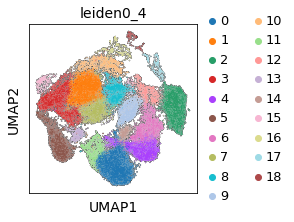

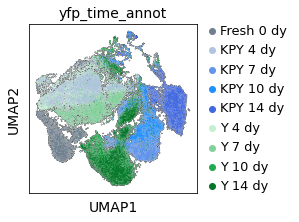

In [4]:
palette = ['slategrey','lightsteelblue','cornflowerblue','dodgerblue','royalblue','#c5f0d2','#82d19b','#22ab4e','#067529']
rcParams['figure.figsize']=3,3
rcParams['figure.facecolor']='white'
sc.pl.umap(mes, color=['leiden0_4'], show=False, frameon=True, add_outline=True, wspace=0.5)
sc.pl.umap(mes, color=['yfp_time_annot'], show=False, frameon=True, add_outline=True, wspace=0.5, palette = palette)

<AxesSubplot:title={'center':'yfp_time_annot'}, xlabel='UMAP1', ylabel='UMAP2'>

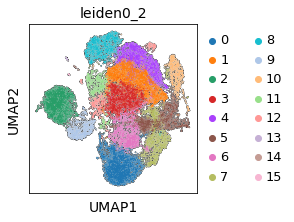

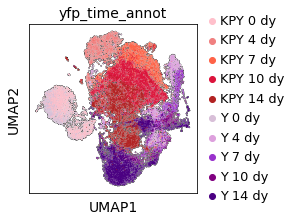

In [6]:
palette = ['pink', 'lightcoral', 'tomato', 'crimson', 'firebrick', 'thistle','plum','darkorchid','purple', 'indigo']

rcParams['figure.figsize']=3,3
rcParams['figure.facecolor']='white'
sc.pl.umap(at2Cells, color=['leiden0_2'], show=False, frameon=True, add_outline=True, wspace=0.5)
sc.pl.umap(at2Cells, color=['yfp_time_annot'], show=False, frameon=True, add_outline=True, wspace=0.5, palette=palette)

### Mesenchyme dataframe

In [19]:
# Scale and create dataframe
print('Scaling and copying expression matrix')

scaled = sc.pp.scale(mes, copy=True)
clusters = ['5', '13', '3', '1', '15', '8', '7', '10','16','11','9','0','14','4','6','18','12','17','2']
time_points = ['KPY 4 dy','KPY 7 dy','KPY 10 dy','KPY 14 dy','Y 4 dy','Y 7 dy','Y 10 dy','Y 14 dy']
scaled = scaled[scaled.obs['leiden0_4'].isin(clusters)]
scaled = scaled[scaled.obs['yfp_time_annot'].isin(time_points)]

input_df = pd.DataFrame(data=scaled.X, index=scaled.obs_names, columns=scaled.var_names)

df = input_df.copy()

# QC
if len(df.columns) == len(scaled.var_names):
    print('QC: PASS - assembled df has a gene length equal to the original anndata')
else:
    print('QC: FAIL - assembled df gene length IS NOT EQUAL to the original anndata')

Scaling and copying expression matrix
QC: PASS - assembled df has a gene length equal to the original anndata


In [20]:
# Add pathways 
print('Adding pathway and genes')

pathways=['leiden0_4','yfp_time_annot'] 

# Filter genes of interest not in adata.var_names
goi = ['Lamc3', 'Lamb1', 'Lamc1', 'Nid1', 'Adam9', 'Thbs1', 'Lama1', 'Fn1', 'Lama5', 
'Lamc2', 'Fn1', 'Plau', 'Lama3', 'Lama2', 'Timp2', 'Cspg4', 'Vtn', 'Lamb3', 
'Reln', 'Lama4', 'Calr']

goi = list(set(goi)) # remove duplicates
missing  = [x for x in goi if x not in list(mes.var_names)]
genes = [x for x in goi if x in list(mes.var_names)]
print('Genes not found in var_names:', missing)
len(goi) == len(missing) + len(genes) # QC

paths_of_interest = [] # If pathway isn't here IT WILL BE REMOVED

for path in pathways:
    df[path]=scaled.obs[path]

# manually order the dataframe using a numeric strategy
input2 = df['leiden0_4'].astype('object')
sorterIndex = {'5': '0',
               '13': '1',
               '3': '2',
               '1': '3',
               '15': '4',
               '8': '5',
               '7': '6',
               '10': '7',
               '16': '8',
               '11': '9',
               '9': '90',
               '0': '91',
               '14': '92',
               '4': '93',
               '6': '94',
               '18': '95',
               '12': '96',
               '17': '97',
               '2': '98'
              }

results = input2.map(sorterIndex)
df['order_results'] = results # creates row with numeric values that can be sorted
df = df.sort_values(['order_results'], ascending = True) # reorder the dataframe

# Color annotations
print('Adding color map')

# time point colors
color_input = df['yfp_time_annot'].astype('object')

lut = {
       'KPY 4 dy': 'lightsteelblue',
       'KPY 7 dy': 'cornflowerblue',
       'KPY 10 dy': 'dodgerblue',
       'KPY 14 dy': 'royalblue',
       'Y 4 dy': '#c5f0d2',
       'Y 7 dy': '#82d19b',
       'Y 10 dy': '#22ab4e',
       'Y 14 dy': '#067529'
        }

col_colors = color_input.map(lut)

# cluster colors
color_input2 = df['leiden0_4'].astype('object')
lut2 = {'0': '#1f77b4',
       '1': '#ff7f0e',
       '2': '#279e68',
       '3': '#d62728',
       '4': '#aa40fc',
       '5': '#8c564b',
       '6': '#e377c2',
       '7': '#b5bd61',
       '8': '#17becf',
       '9': '#aec7e8',
       '10': '#ffbb78',
       '11': '#98df8a',
       '12': '#ff9896',
       '13': '#c5b0d5',
       '14': '#c49c94',
       '15': '#f7b6d2',
       '16': '#dbdb8d',
       '17': '#9edae5',
       '18': '#ad494a'}

col_colors2 = color_input2.map(lut2)

# Remove columns that are not gene expression
df_input = df.drop(['leiden0_4','yfp_time_annot'], axis=1)
df_input = df_input.T # makes cells columns

print('Selecting genes and pathways of interest')
inpt = genes + paths_of_interest
df1 = df_input.loc[inpt] 
print('# Genes and pathways used:', len(df1.index))
df1 = df1.fillna(0) # turn NaN into 0 since there is no gene expression

# QC
# Check for non-numeric data
non_numeric = df1.applymap(lambda x: not isinstance(x, (int, float)))
if non_numeric.sum().sum() > 0:
    print("FAIL: Non-numeric data found in the dataframe.")
else:
    print("PASS: No non-numeric data found in the dataframe.")

Adding pathway and genes
Genes not found in var_names: ['Vtn']
Adding color map
Selecting genes and pathways of interest
# Genes and pathways used: 19
PASS: No non-numeric data found in the dataframe.


In [25]:
# Scale and create dataframe
print('Scaling and copying expression matrix')

scaled = sc.pp.scale(mes, copy=True)
clusters = ['5', '13', '3', '1', '15', '8', '7', '10','16','11','9','0','14','4','6','18','12','17','2']
time_points = ['KPY 4 dy','KPY 7 dy','KPY 10 dy','KPY 14 dy','Y 4 dy','Y 7 dy','Y 10 dy','Y 14 dy']
scaled = scaled[scaled.obs['leiden0_4'].isin(clusters)]
scaled = scaled[scaled.obs['yfp_time_annot'].isin(time_points)]

input_df = pd.DataFrame(data=scaled.X, index=scaled.obs_names, columns=scaled.var_names)

df = input_df.copy()

# QC
if len(df.columns) == len(scaled.var_names):
    print('QC: PASS - assembled df has a gene length equal to the original anndata')
else:
    print('QC: FAIL - assembled df gene length IS NOT EQUAL to the original anndata')


# Add pathways 
print('Adding pathway and genes')

pathways=['leiden0_4','yfp_time_annot'] 

# Filter genes of interest not in adata.var_names
goi_input = ['Lamc3', 'Lamb1', 'Lamc1', 'Nid1', 'Adam9', 'Thbs1', 'Lama1', 'Fn1', 'Lama5', 
'Lamc2', 'Fn1', 'Plau', 'Lama3', 'Lama2', 'Timp2', 'Cspg4', 'Vtn', 'Lamb3', 
'Reln', 'Lama4', 'Calr']

# remove duplicates while maintaining order
seen = set()
goi = [x for x in goi_input if not (x in seen or seen.add(x))]
print("Duplicates removed:", len(goi_input)-len(goi)) #QC

missing  = [x for x in goi if x not in list(mes.var_names)]
genes = [x for x in goi if x in list(mes.var_names)]
print('Genes not found in var_names:', missing)
len(goi) == len(missing) + len(genes) # QC

paths_of_interest = [] # If pathway isn't here IT WILL BE REMOVED

for path in pathways:
    df[path]=scaled.obs[path]

# manually order the dataframe using a numeric strategy
input2 = df['leiden0_4'].astype('object')
sorterIndex = {'5': '0',
               '13': '1',
               '3': '2',
               '1': '3',
               '15': '4',
               '8': '5',
               '7': '6',
               '10': '7',
               '16': '8',
               '11': '9',
               '9': '90',
               '0': '91',
               '14': '92',
               '4': '93',
               '6': '94',
               '18': '95',
               '12': '96',
               '17': '97',
               '2': '98'
              }

results = input2.map(sorterIndex)
df['order_results'] = results # creates row with numeric values that can be sorted
df = df.sort_values(['order_results'], ascending = True) # reorder the dataframe

# Color annotations
print('Adding color map')

# time point colors
color_input = df['yfp_time_annot'].astype('object')

lut = {
       'KPY 4 dy': 'lightsteelblue',
       'KPY 7 dy': 'cornflowerblue',
       'KPY 10 dy': 'dodgerblue',
       'KPY 14 dy': 'royalblue',
       'Y 4 dy': '#c5f0d2',
       'Y 7 dy': '#82d19b',
       'Y 10 dy': '#22ab4e',
       'Y 14 dy': '#067529'
        }

col_colors = color_input.map(lut)

# cluster colors
color_input2 = df['leiden0_4'].astype('object')
lut2 = {'0': '#1f77b4',
       '1': '#ff7f0e',
       '2': '#279e68',
       '3': '#d62728',
       '4': '#aa40fc',
       '5': '#8c564b',
       '6': '#e377c2',
       '7': '#b5bd61',
       '8': '#17becf',
       '9': '#aec7e8',
       '10': '#ffbb78',
       '11': '#98df8a',
       '12': '#ff9896',
       '13': '#c5b0d5',
       '14': '#c49c94',
       '15': '#f7b6d2',
       '16': '#dbdb8d',
       '17': '#9edae5',
       '18': '#ad494a'}

col_colors2 = color_input2.map(lut2)

# Remove columns that are not gene expression
df_input = df.drop(['leiden0_4','yfp_time_annot'], axis=1)
df_input = df_input.T # makes cells columns

print('Selecting genes and pathways of interest')
inpt = genes + paths_of_interest
df1 = df_input.loc[inpt] 
print('# Genes and pathways used:', len(df1.index))
df1 = df1.fillna(0) # turn NaN into 0 since there is no gene expression

# QC
# Check for non-numeric data
non_numeric = df1.applymap(lambda x: not isinstance(x, (int, float)))
if non_numeric.sum().sum() > 0:
    print("FAIL: Non-numeric data found in the dataframe.")
else:
    print("PASS: No non-numeric data found in the dataframe.")

Scaling and copying expression matrix
QC: PASS - assembled df has a gene length equal to the original anndata
Adding pathway and genes
Duplicates removed: 1
Genes not found in var_names: ['Vtn']
Adding color map
Selecting genes and pathways of interest
# Genes and pathways used: 19
PASS: No non-numeric data found in the dataframe.


<Figure size 900x900 with 0 Axes>

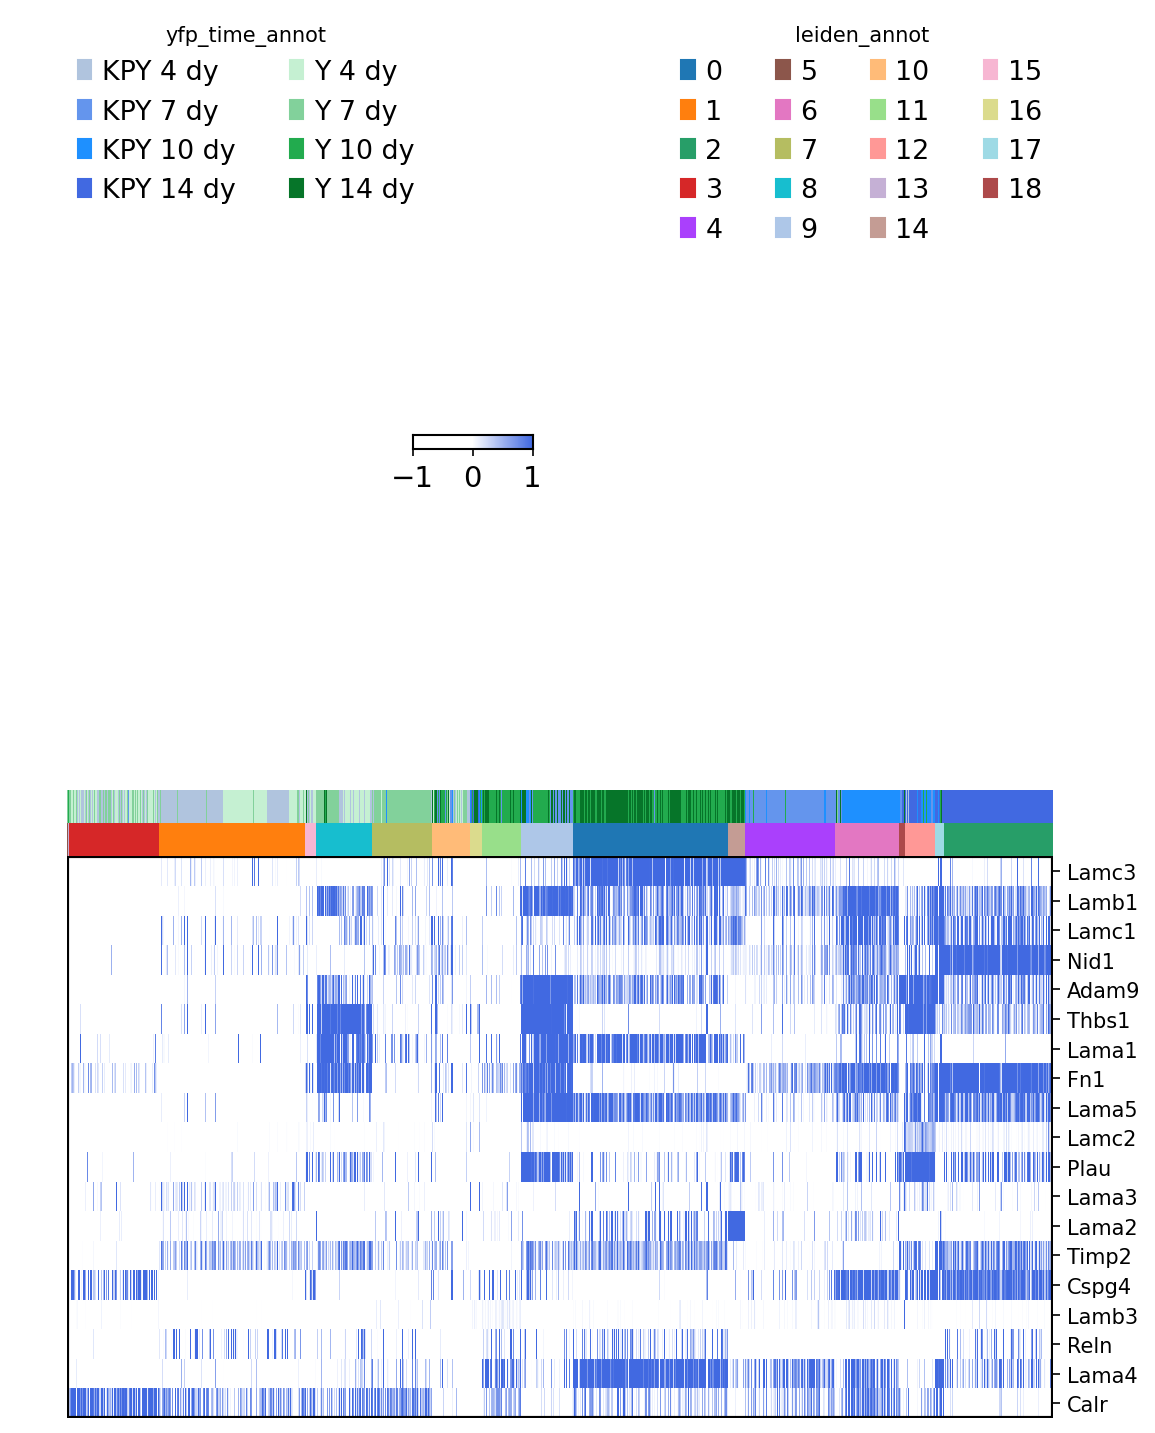

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sb
import matplotlib.patches as mpatches

# Plot clustermap
vmin = -1  # expression
vmax = 1  # expression
base = 4  # for plot size, not expression

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','white','royalblue'])

plt.figure(dpi=300)

g1 = sb.clustermap(
    df1, vmin=vmin, vmax=vmax, center=0,
    cmap=cmap, metric="euclidean", row_cluster=False, col_cluster=False,
    figsize=(8, len(df1.index) / base), cbar_pos=(0.35, 1.4, .1, .02),  # locxaxis,locyaxis,cbarwidth,cbarheight
    col_colors=[col_colors, col_colors2], yticklabels=True, xticklabels=False,
    cbar_kws={"orientation": "horizontal"},
    dendrogram_ratio=0.05, colors_ratio=0.05
)

ax = g1.ax_heatmap
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("", rotation=270, labelpad=25)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.axhline(y=0, color='black', linewidth=2)  # border
ax.axhline(y=len(df1.index), color='black', linewidth=2)  # border
ax.axvline(x=0, color='black', linewidth=2)  # border
ax.axvline(x=len(df1.columns), color='black', linewidth=2)  # border

# Create a list to collect the patches for yfp_time_annot legend
yfp_patches = []
for key in lut.keys():
    yfp_patches.append(mpatches.Patch(color=lut[key], label=key))

# Create a list to collect the patches for leiden legend
leiden_patches = []
for key in lut2.keys():
    leiden_patches.append(mpatches.Patch(color=lut2[key], label=key))

# Plot yfp_time_annot legend on the heatmap axes
yfp_legend = ax.legend(handles=yfp_patches, bbox_to_anchor=(0, 2.5), loc='upper left', ncol=2, borderaxespad=0, frameon=False, title="yfp_time_annot")

# Add the leiden_legend explicitly to the current Axes.
ax.add_artist(yfp_legend)

# Plot leiden legend on the heatmap axes
leiden_legend = ax.legend(handles=leiden_patches, bbox_to_anchor=(1, 2.5), loc='upper right', ncol=4, borderaxespad=0, frameon=False, title="leiden_annot")

# Get the colorbar axes
cbar_ax = g1.cax

# Add a border around the colorbar
cbar_ax.spines['top'].set_visible(True)
cbar_ax.spines['bottom'].set_visible(True)
cbar_ax.spines['left'].set_visible(True)
cbar_ax.spines['right'].set_visible(True)
cbar_ax.spines['top'].set_linewidth(1)
cbar_ax.spines['bottom'].set_linewidth(1)
cbar_ax.spines['left'].set_linewidth(1)
cbar_ax.spines['right'].set_linewidth(1)

plt.show()

### Human Mesenchyme Clusters

In [8]:
results_file3 = '/n/data2/bch/hemonc/ckim/AARON/CSC_stage1A_human_data/write/mes_subset_stageIA_human_batch_corrected.h5ad'
mes_sub = sc.read(results_file3)

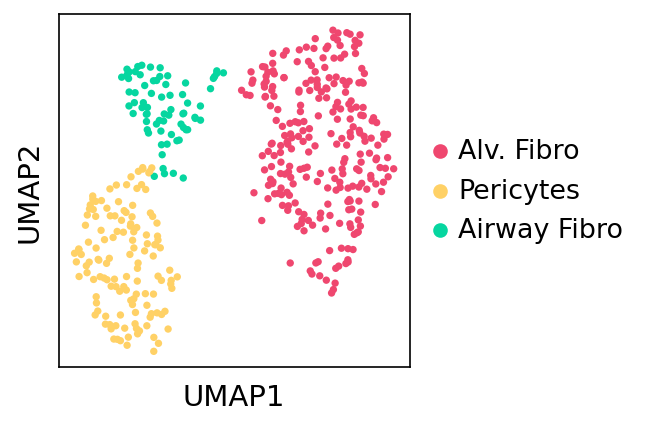

In [9]:
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=3,3
rcParams['figure.dpi']= 150
sc.pl.umap(mes_sub, color=['mes_annot'], wspace=0.6, frameon=True, legend_loc='right margin', add_outline=False, s=50, title='',
           palette = ['#ef476f','#ffd166','#06d6a0'])

In [27]:
# Scale and create dataframe
print('Scaling and copying expression matrix')

scaled = sc.pp.scale(mes_sub, copy=True)

input_df = pd.DataFrame(data=scaled.X, index=scaled.obs_names, columns=scaled.var_names)

df = input_df.copy()

# QC
if len(df.columns) == len(scaled.var_names):
    print('QC: PASS - assembled df has a gene length equal to the original anndata')
else:
    print('QC: FAIL - assembled df gene length IS NOT EQUAL to the original anndata')


# Add pathways 
print('Adding pathway and genes')

pathways=['mes_annot'] 

# Filter genes of interest not in adata.var_names
goi_input = ['LAMC3', 'LAMB1', 'LAMC1', 'NID1', 'ADAM9', 'THBS1', 'LAMA1', 'FN1', 'LAMA5', 
'LAMC2', 'FN1', 'PLAU', 'LAMA3', 'LAMA2', 'TIMP2', 'CSPG4', 'VTN', 'LAMB3', 
'RELN', 'LAMA4', 'CALR']

# remove duplicates while maintaining order
seen = set()
goi = [x for x in goi_input if not (x in seen or seen.add(x))]
print("Duplicates removed:", len(goi_input)-len(goi)) #QC

# TSP1 = THBS1
# FINC = FN1

missing  = [x for x in goi if x not in list(mes_sub.var_names)]
genes = [x for x in goi if x in list(mes_sub.var_names)]
print('Genes not found in var_names:', missing)
len(goi) == len(missing) + len(genes) # QC

Scaling and copying expression matrix
QC: PASS - assembled df has a gene length equal to the original anndata
Adding pathway and genes
Duplicates removed: 1
Genes not found in var_names: []


True

In [28]:
paths_of_interest = [] # If pathway isn't here IT WILL BE REMOVED

for path in pathways:
    df[path]=scaled.obs[path]

# manually order the dataframe using a numeric strategy
input2 = df['mes_annot'].astype('object')
sorterIndex = {'Alv. Fibro': '0',
               'Airway Fibro': '1',
               'Pericytes': '2',
              }

results = input2.map(sorterIndex)
df['order_results'] = results # creates row with numeric values that can be sorted
df = df.sort_values(['order_results'], ascending = True) # reorder the dataframe

# Color annotations
print('Adding color map')

# time point colors
color_input = df['mes_annot'].astype('object')

lut = {'Alv. Fibro': '#ef476f',
       'Pericytes': '#ffd166',
       'Airway Fibro': '#06d6a0'
      }

col_colors = color_input.map(lut)

# Remove columns that are not gene expression
df_input = df.drop(['mes_annot'], axis=1)
df_input = df_input.T # makes cells columns

print('Selecting genes and pathways of interest')
inpt = genes + paths_of_interest
df1 = df_input.loc[inpt] 
print('# Genes and pathways used:', len(df1.index))
df1 = df1.fillna(0) # turn NaN into 0 since there is no gene expression

# QC
# Check for non-numeric data
non_numeric = df1.applymap(lambda x: not isinstance(x, (int, float)))
if non_numeric.sum().sum() > 0:
    print("FAIL: Non-numeric data found in the dataframe.")
else:
    print("PASS: No non-numeric data found in the dataframe.")

Adding color map
Selecting genes and pathways of interest
# Genes and pathways used: 20
PASS: No non-numeric data found in the dataframe.


<Figure size 900x900 with 0 Axes>

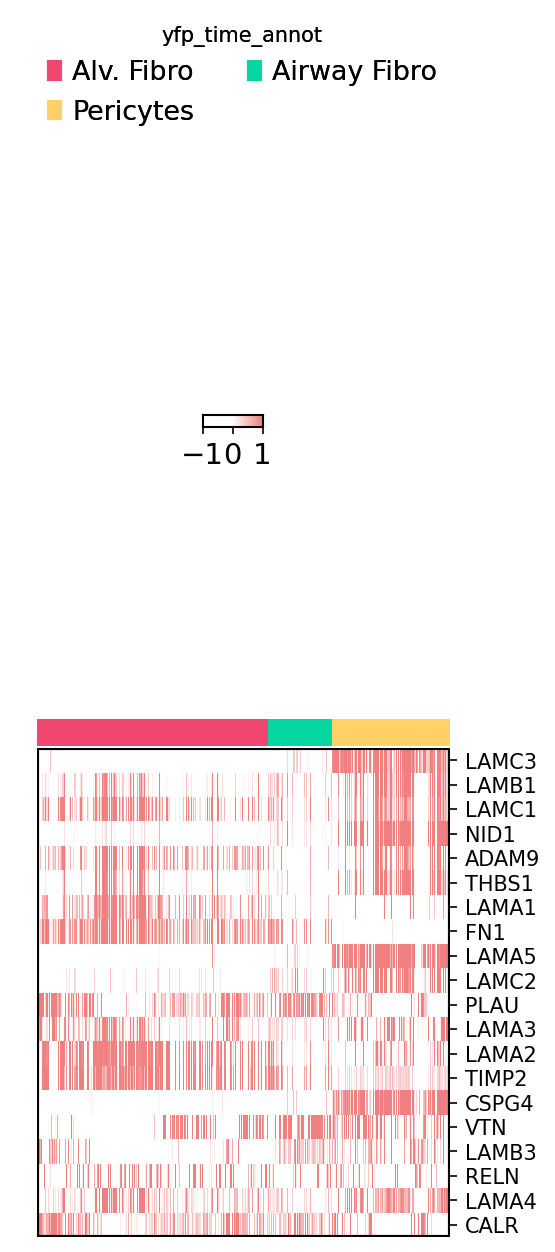

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sb
import matplotlib.patches as mpatches

# Plot clustermap
vmin = -1  # expression
vmax = 1  # expression
base = 4  # for plot size, not expression

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','white', 'lightcoral'])

plt.figure(dpi=300)

g1 = sb.clustermap(
    df1, vmin=vmin, vmax=vmax, center=0,
    cmap=cmap, metric="euclidean", row_cluster=False, col_cluster=False,
    figsize=(4,4), cbar_pos=(0.35, 1.4, .1, .02),  # locxaxis,locyaxis,cbarwidth,cbarheight
    col_colors=[col_colors], yticklabels=True, xticklabels=False,
    cbar_kws={"orientation": "horizontal"},
    dendrogram_ratio=0.05, colors_ratio=0.05
)

ax = g1.ax_heatmap
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("", rotation=270, labelpad=25)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.axhline(y=0, color='black', linewidth=2)  # border
ax.axhline(y=len(df1.index), color='black', linewidth=2)  # border
ax.axvline(x=0, color='black', linewidth=2)  # border
ax.axvline(x=len(df1.columns), color='black', linewidth=2)  # border

# Create a list to collect the patches for yfp_time_annot legend
yfp_patches = []
for key in lut.keys():
    yfp_patches.append(mpatches.Patch(color=lut[key], label=key))

# Plot yfp_time_annot legend on the heatmap axes
yfp_legend = ax.legend(handles=yfp_patches, bbox_to_anchor=(0, 2.5), loc='upper left', ncol=2, borderaxespad=0, frameon=False, title="yfp_time_annot")

# Add the leiden_legend explicitly to the current Axes.
ax.add_artist(yfp_legend)

# Get the colorbar axes
cbar_ax = g1.cax

# Add a border around the colorbar
cbar_ax.spines['top'].set_visible(True)
cbar_ax.spines['bottom'].set_visible(True)
cbar_ax.spines['left'].set_visible(True)
cbar_ax.spines['right'].set_visible(True)
cbar_ax.spines['top'].set_linewidth(1)
cbar_ax.spines['bottom'].set_linewidth(1)
cbar_ax.spines['left'].set_linewidth(1)
cbar_ax.spines['right'].set_linewidth(1)

plt.show()

#### Itga3 ligand expression in AT2 cells

In [9]:
scaled = sc.pp.scale(at2Cells, copy=True)

[<AxesSubplot:title={'center':'yfp_time_annot'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'leiden0_2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Lamc3'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Lamb1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Lamc1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Nid1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Adam9'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Thbs1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Lama1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Fn1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Lama5'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Lamc2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Fn1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Plau'}, xlab

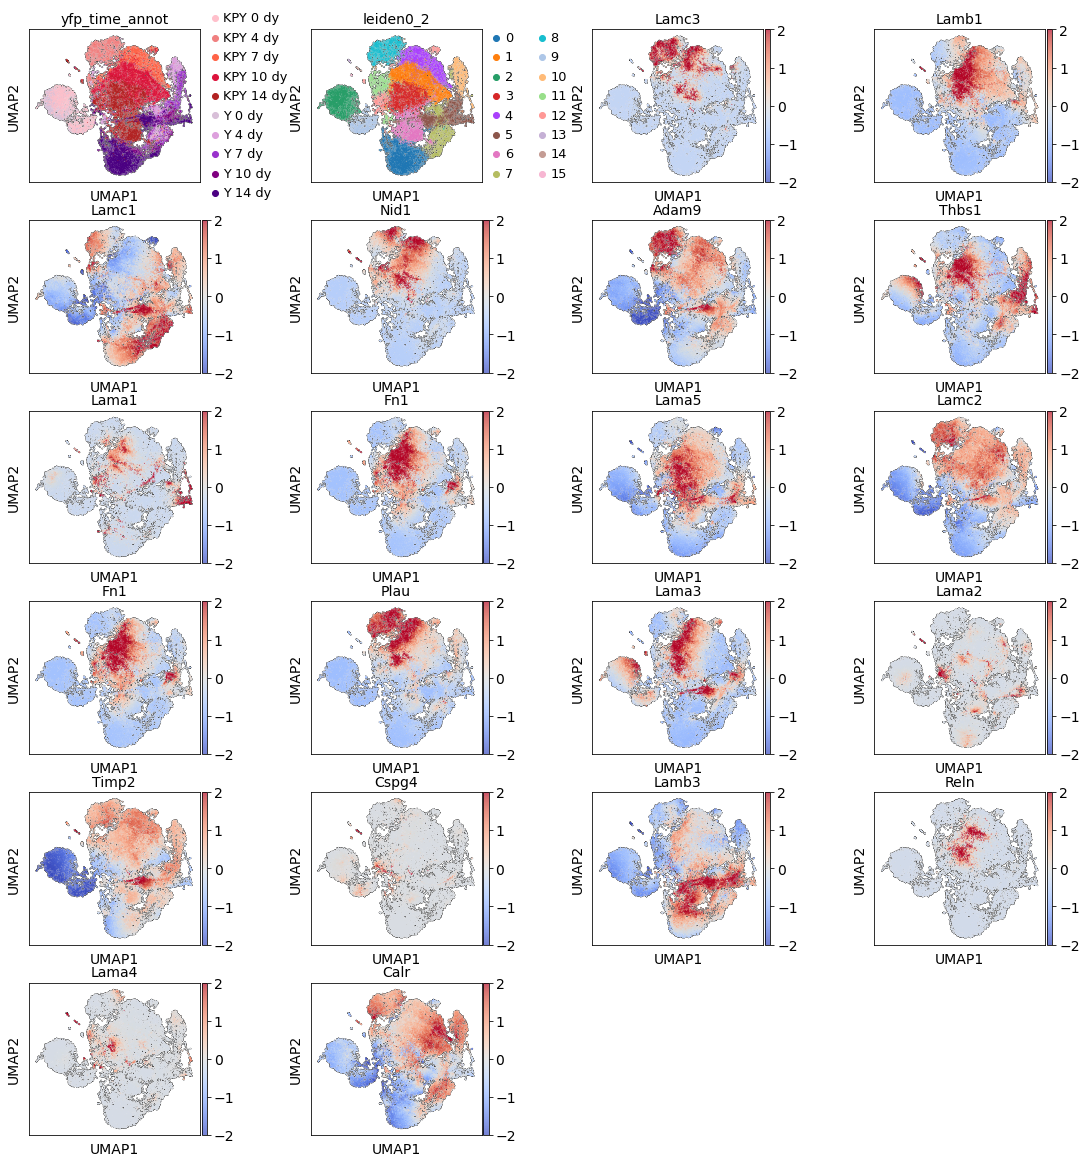

In [11]:
goi = ['yfp_time_annot','leiden0_2','Lamc3', 'Lamb1', 'Lamc1', 'Nid1', 'Adam9', 'Thbs1', 'Lama1', 'Fn1', 'Lama5', 
'Lamc2', 'Fn1', 'Plau', 'Lama3', 'Lama2', 'Timp2', 'Cspg4', #'Vtn', 
'Lamb3', 'Reln', 'Lama4', 'Calr']

rcParams['figure.figsize']=3,3
rcParams['figure.facecolor']='white'
sc.pl.umap(scaled, color=goi, show=False, frameon=True, add_outline=True, wspace=0.5, vmin=-2, vmax=2, color_map='coolwarm', use_raw=False)

[<AxesSubplot:title={'center':'Lama1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'Lamb1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'yfp_time_annot'}, xlabel='UMAP1', ylabel='UMAP2'>]

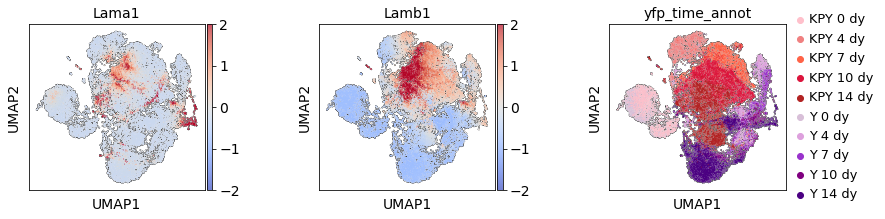

In [14]:
goi = ['Lama1','Lamb1','yfp_time_annot']

rcParams['figure.figsize']=3,3
rcParams['figure.facecolor']='white'
sc.pl.umap(scaled, color=goi, show=False, frameon=True, add_outline=True, wspace=0.5, vmin=-2, vmax=2, color_map='coolwarm', use_raw=False, ncols=3)